In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchbnn as bnn

In [112]:
# Load Data
colectomy_cci_var = pd.read_csv('./colectomy_cci_var.csv', dtype = 'str')

# Rename columns
colectomy_cci_var['ptsex'] = colectomy_cci_var['ptsex'].replace({'F': 'female', 'M': 'male'})
colectomy_cci_var['adtype'] = colectomy_cci_var['adtype'].replace({'1': 'emergency', '2': 'urgent', '3': 'elective'})
colectomy_cci_var['adsource'] = colectomy_cci_var['adsource'].replace({'1': 'non_healthcare_facility', '2': 'clinical_referral', '4': 'hospital_transfer', '5': 'snf_icf_transfer', '6': 'healthcare_facility_tranfer', '7': 'emergency_room', '8': 'court_law_enforcement', 'D': 'hospital_unit_transfer', 'E': 'ambulatory_surgery_center'})

colectomy_cci_var['age'] = colectomy_cci_var['age'].astype(int)

# Drop observations
colectomy_cci_var = colectomy_cci_var[colectomy_cci_var['adsource'] != '9']

# Select Relevant Features
features = ['year', 'ptsex', 'race', 'age', 'adtype', 'adsource', 'admdx']
dummy_features = ['year','ptsex', 'race', 'adtype', 'adsource']

# Data Preprocessing
num_secondary_admissions = 10

for i in range(1, num_secondary_admissions + 1):
    sdx = f'sdx{i}'

    features.append(sdx)

    # Replace missing values with the "unknown" category
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].fillna('unknown')

    # Target encoding
    category_counts = colectomy_cci_var[sdx].value_counts()
    colectomy_cci_var[sdx] = colectomy_cci_var[sdx].map(category_counts)

# Target encoding
category_counts = colectomy_cci_var['admdx'].value_counts()
colectomy_cci_var['admdx'] = colectomy_cci_var['admdx'].map(category_counts)

#for feature in features:
#    print(colectomy_cci_var[feature].value_counts())


In [ ]:
colectomy_cci_var_X = colectomy_cci_var[features]
colectomy_cci_var_y = colectomy_cci_var['pdx']

# One-Hot Encoding
colectomy_cci_var_X = pd.get_dummies(colectomy_cci_var_X, columns = dummy_features)

# Split Data
train_X, test_X, train_y, test_y = train_test_split(colectomy_cci_var_X, colectomy_cci_var_y, test_size = 0.2, random_state = 0)

# Label Encoding
encoder = LabelEncoder()
label_encoder = encoder.fit(colectomy_cci_var_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# Normalize Data
normalize_features = list(set(features) - set(dummy_features))

scaler = MinMaxScaler()

train_X_normalized = train_X.copy()
test_X_normalzied = test_X.copy()

normalizer = scaler.fit(train_X_normalized[normalize_features])

train_X_normalized[normalize_features] = normalizer.transform(train_X_normalized[normalize_features])
test_X_normalzied[normalize_features] = normalizer.transform(test_X_normalzied[normalize_features])

,age,admdx,sdx1,sdx2,sdx3,sdx4,sdx5,sdx6,sdx7,sdx8,...,adtype_urgent,adsource_ambulatory_surgery_center,adsource_clinical_referral,adsource_court_law_enforcement,adsource_emergency_room,adsource_healthcare_facility_tranfer,adsource_hospital_transfer,adsource_hospital_unit_transfer,adsource_non_healthcare_facility,adsource_snf_icf_transfer
2642,0.743902,0.195428,0.050700,0.018382,0.052828,0.277108,0.013697,0.000438,0.004941,0.005449,...,False,False,False,False,False,False,False,False,True,False
22463,0.780488,0.085164,0.042028,0.480801,0.070851,0.014929,0.002702,0.105924,0.000422,0.034978,...,False,False,False,False,False,False,False,False,True,False
23632,0.524390,0.233826,0.747832,0.006127,0.005801,0.033525,0.001770,0.032581,0.020729,0.010172,...,False,False,True,False,False,False,False,False,False,False
12287,0.426829,0.521440,0.134757,0.331699,0.164906,0.002226,0.024693,0.028636,1.000000,1.000000,...,False,False,False,False,False,False,False,False,True,False
15510,0.609756,1.000000,0.472315,0.076797,0.078724,0.012965,1.000000,1.000000,1.000000,1.000000,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20758,0.536585,1.000000,0.909940,0.101716,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,False,False,False,False,False,False,False,False,True,False
32106,0.390244,0.042432,0.184123,0.300654,0.206339,0.075301,0.013418,1.000000,1.000000,1.000000,...,False,False,False,False,False,False,False,False,True,False
30405,0.682927,0.064694,0.424283,0.002042,0.003729,0.006417,0.017704,0.013661,0.000301,0.047330,...,False,False,False,False,False,False,False,False,True,False
21244,0.426829,1.000000,0.260173,0.992647,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,False,False,True,False,False,False,False,False,False,False


(array([5241., 2404., 1422., 1794., 1322.,  334.,  504., 1340., 1026.,
         551., 1008.,  703.,  495., 1051.,  560.,  282.,  316.,  704.,
           0.,  386.,    0.,  429.,    0.,    0.,  480.,    0.,    0.,
           0.,    0.,  554.,  578.,    0., 1235.,  653.,  681.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  954.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3898.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29

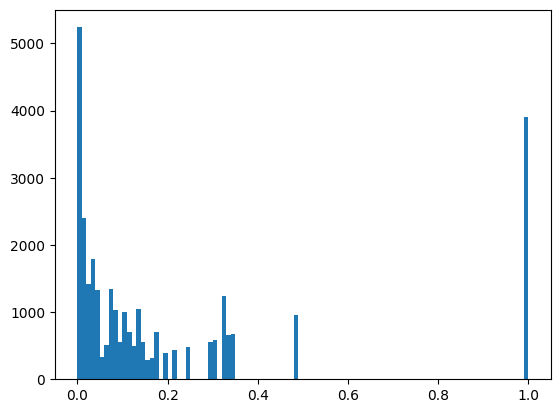

In [107]:
plt.hist(train_X_normalized['sdx2'], bins=100)


In [ ]:
# Model Architecture
class BayesianNeuralNetwork(nn.Module):
    def __init__(self, feature_size, num_classes):
        super().__init__()

        layer_1_size = 100
        layer_2_size = 50

        # Layers
        self.bayes_linear_1 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = feature_size, out_features = layer_1_size)
        self.bayes_linear_2 = bnn.BayesLinear(prior_mu = 0, prior_sigma = 1, in_features = layer_1_size, out_features = layer_2_size)
        self.output_layer = nn.Linear(in_features = layer_2_size, out_features = num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bayes_linear_1(x))
        x = torch.relu(self.bayes_linear_2(x))
        return self.output_layer(x)

In [ ]:
# Loss Function
def elbo_loss(output, target, model):
    standard_loss = nn.CrossEntropyLoss(output, target)
    kl_loss = bnn.BKLLoss(reduction = 'mean', last_layer_only = False)

    return standard_loss + kl_loss(model)